## Import Libraries

In [1]:
# helper
from functools import wraps
import time

# math
import numpy as np
import scipy.io
import math
import cvxpy as cp

#plotting
import matplotlib.pyplot as plt
import time


## Helper Functions

We can sample the Channel coefficients from a rician distribution with parameters $\beta$ and $K$. $\mathbf{h_d}$ is constant and $\mathbf{h_s}$ is sampled form a circularly symmetric standard Complex Gaussian  
$$\mathbf{h} = \sqrt{\frac{\beta K}{1+K}} \mathbf{h_d} + \sqrt{\frac{\beta }{1+K}} \mathbf{h_s}$$

In [2]:
# get the channel coefficients from the rician distribution
def rician(beta,k,h_d=0 ,num_carriers=500,num_channels=1):
    """
    returns a (num_carriers x num_channels) matrix with complex numbers whose magnitude would follow a rician distribution 
    beta is a distance dependent path loss parameter 
    K is ratio of deterministic to scattered power
    """
    det = math.sqrt(beta*k/(1+k))* h_d
    det = np.tile(det,(1,num_carriers)).T
    ran = math.sqrt(beta/((1+k)*2)) * np.random.randn(num_carriers, num_channels*2).view(np.complex128)
    return ran+det

In [3]:
def theta_direct(N,phi=np.pi/3,d=0.06): 
    # What does phi mean again
    return 2*np.pi*d* np.arange(1,N+1)*np.cos(phi)
    
def theta_reflector(Nx,Ny,phi=np.pi/3,d=0.06/4): 
    # Nx = Number of columns in IRS
    # Ny = Number of rows
    # What is the significance of Phi here?
    yv,xv=np.meshgrid(np.arange(Nx),np.arange(Ny), sparse=False, indexing='ij')
    dist=np.sqrt(xv**2+yv**2)
    return 2 * np.pi * d * dist * np.cos(phi)

def generate_deterministic_direct(antenna_gains):
    
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_direct(antenna_gains.shape[0]))*alphas

def generate_deterministic_reflectors(antenna_gains):
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_reflector(antenna_gains.shape[0],antenna_gains.shape[1]))*alphas


In [4]:
generate_deterministic_direct(np.ones(1))
generate_deterministic_direct(np.ones(1))


array([0.98228725+0.18738131j])

In [5]:
# we can append @timer to each of our function for which we want to have the time printed
def timer(func):
    """
    Usage:
    @timer
    def somefunc(a,b):
        output = a+b
        return output
    """
    @wraps(func)
    def wrapper(*args,**kwargs):
        print(f"{func.__name__!r} begins")
        start_time = time.time()
        result = func(*args,**kwargs)
        print(f"{func.__name__!r} ends in {time.time()-start_time} secs")
        return result
    return wrapper

In [6]:
# get IRS configuration
def get_config(method = None):
    if method == None:
        return np.exp(2j*np.random.randint(M,size=N_e)*np.pi/M)

In [7]:
# calculate the datarate for the given configuration of IRS
def calculate_datarate(H,x):
    indi=np.log2(1+(np.square(np.abs(H)))*abs(np.square(x).sum())/10**-14)
    return np.sum(indi)*10**6

In [8]:
# vector method
def return_coefficients(h_,opt,M=2):
    angles = M - np.round((np.angle(opt/h_)*M/(2*np.pi))%np.pi)
    angles[0] = 0
    return np.exp(2j*angles*np.pi/M)

def vector_heuristic(h,M=2):
    h_ = h.sum(axis=0)
    idx = np.argmax(np.abs(h_))

    return return_coefficients(h_,h_[idx],M)

In [9]:
#Greedy approach
def return_greedy_estimate(estimation,N_regions=100,M=2):
    estimation_sum = estimation.sum(axis=0)
    opt = np.exp(2j*np.asarray(range(M))*np.pi/M)
    angles = np.ones((estimation_sum.shape[0],N_regions)).astype(complex)
    for i in range(len(opt)):
        angles[:,i] = return_coefficients(estimation_sum,opt[i],M)
    abso=np.abs(np.matmul(angles.T,estimation_sum.reshape((-1,1))))
    opt_angle=angles[:,np.where((angles[0,:]==1) &(abso==np.max(abso)))[0]][:,0].flatten()
    return opt_angle

In [10]:
def strongest_tap(est,n_strong,N_e,K,L,N_regions=100,M=2):
    time_h = np.fft.ifft(est,K,axis=0)[:L,:]
    strongest_tap = np.argsort(np.abs(time_h),axis=0)[-1*n_strong:,:].reshape(N_e,n_strong)
    top_time_h = np.zeros((n_strong,N_e),dtype=complex)
    for i in range(N_e):
        top_time_h[:,i] = time_h[strongest_tap[i],i]
    h = np.fft.fft(top_time_h,500,axis=0) # FFT 
    theta = return_greedy_estimate(h,N_regions,M) # Try out different stats
    return theta

In [11]:
def calculate_cascaded(H,Theta):
    Theta = Theta.reshape((N_e+1,1))
    G = H @ Theta ## Final  Channel across different subcarriers
    return G    

In [12]:
def return_rate_strongest_tap(H,N_e,K,L,sig):
    Theta = strongest_tap(H,1,N_e+1,K,L)
#     est,n_strong,N_e,K,L,N_regions=100,M=2
    #Theta = vector_heuristic(H,M)
    G = calculate_cascaded(H,Theta)
    R = calculate_datarate(G,sig)
    return R/10**8

In [13]:
def return_rate_sca(H,N_e,K,L,sig):
    a_init =  np.real(H[:,0]+(H[:,1:]@np.random.uniform(-1,1,size=(N_e,1))).sum(axis=1))
    b_init = np.imag(H[:,0]+(H[:,1:]@np.random.uniform(-1,1,size=(N_e,1))).sum(axis=1))
    
    f = lambda a,b: a_init**2 + b_init**2 + 2*cp.multiply(a_init,(a-a_init )) +2*cp.multiply(b_init,(b-b_init )) 

    yn = cp.Variable(K)
    x = cp.Variable(N_e,complex = True)
    tau = 1
    sigma = 10**-20
    a = cp.Variable(K) 
    b = cp.Variable(K)
    objective = cp.sum(cp.log(1+yn))
    objective = cp.Maximize(objective)
    constraints = [cp.abs(x) <= 1,
                   a == cp.real(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   b == cp.imag(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   yn <= cp.real(f(a,b)),]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    thetas = np.ones(N_e)
    thetas[np.angle(x.value,deg= True)<0] = -1 
    ThetaSDP = np.concatenate([[1],thetas])
    G = calculate_cascaded(H,np.concatenate([[1],x.value]))
    RSDP = calculate_datarate(G,sig)
    return RSDP/10**8

In [30]:
def return_rate_sca_vectorinit(H,N_e,K,L,sig):
    
    vector_init = vector_heuristic(H).reshape(-1,1)
    a_init =  np.real(H[:,:]+((H[:,1:]@vector_init[1:]).sum(axis=1)))
    b_init = np.imag(H[:,0]+((H[:,1:]@vector_init[1:]).sum(axis=1)))
    
    f = lambda a,b: a_init**2 + b_init**2 + 2*cp.multiply(a_init,(a-a_init )) +2*cp.multiply(b_init,(b-b_init )) 

    yn = cp.Variable(K)
    x = cp.Variable(N_e,complex = True)
    tau = 1
    sigma = 10**-20
    a = cp.Variable(K) 
    b = cp.Variable(K)
    objective = cp.sum(cp.log(1+yn))
    objective = cp.Maximize(objective)
    constraints = [cp.abs(x) <= 1,
                   a == cp.real(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   b == cp.imag(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,N_e)),H[:,1:]),axis=1)),
                   yn <= cp.real(f(a,b)),]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    thetas = np.ones(N_e)
    thetas[np.angle(x.value,deg= True)<0] = -1 
    ThetaSDP = np.concatenate([[1],thetas])
    G = calculate_cascaded(H,np.concatenate([[1],x.value]))
    RSDP = calculate_datarate(G,sig)
    return RSDP/10**8

In [15]:
N_iter = 100
N_xs = [8,11,13,16]
vector = np.zeros((len(N_xs),N_iter,2))
sca = np.zeros((len(N_xs),N_iter,2))
### System Parameters
# General parameters
j = 0
for N_x in N_xs:
    print(f"Doing it for {N_x}")
    K = 500 # sub carriers
    L = 20 # taps

    M = 2 #Num of discrete phase-shifts

    N_y = N_x
    N_e = N_x * N_y #Number of IRS elements

    # Channel information
    #direct channel
    beta_d = (10)**-3 * (10)**-3
    k_d = 0
    const_d = 0
    #BS to IRS channel
    beta_bi =  (10)**-3 * (1.5)**-3
    k_bi = 1
    const_bi = 0
    #IRS to User channel
    beta_iu =  (10)**-3 * (8)**-3
    k_iu = 1
    const_iu = 0
    
    for i in range(N_iter):
        ### Declaring Variables 
        det = generate_deterministic_reflectors(np.ones((N_x,N_y))).reshape((N_e,1))
        det_direct = generate_deterministic_direct(np.ones(1))[0]
        # CSI

        H_d = rician(beta=beta_d, k=k_d,num_carriers=K,h_d=det_direct)
        H_bi = rician(beta=beta_bi,k=k_bi,num_carriers=K,num_channels=N_e,h_d=det)
        H_iu = rician(beta=beta_iu,k=k_iu,num_carriers=K,num_channels=N_e,h_d=det)

        ## Theta

        IRS_config = get_config()
        Direct = np.ones(1).astype(np.complex128)
        Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))


        ## Final channel
        H_id = np.multiply(H_bi,H_iu)
        H = np.concatenate((H_d,H_id), axis=1)
        G_comp = H * Theta.T ## Channel Across different subcarriers and subchannels
        G = H @ Theta ## Final  Channel across different subcarriers

        ## Creating Signal 

        ## Power Distribution over different subcarriers: 
        P = np.random.dirichlet(np.ones(K),size=1)
        P_max = 10 ## Power Budget in mW
        ## Symbol to be sent of 1mW
        s = 1e-3 * P_max
        w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
        sig  = w*s # Final Symbol Transmitted
        sig = sig * P.T
        t = time.process_time()
        R = return_rate_strongest_tap(H,N_e,K,L,sig)
        vector[j][i]=time.process_time()-t,R
        t = time.process_time()
        R = return_rate_sca(H,N_e,K,L,sig)
        sca[j][i]=time.process_time()-t,R
        if (i%10==0):
            print(f'Iteration {i} going on for {N_x}')
    j += 1

Doing it for 8
Iteration 0 going on for 8
Iteration 10 going on for 8
Iteration 20 going on for 8
Iteration 30 going on for 8
Iteration 40 going on for 8
Iteration 50 going on for 8
Iteration 60 going on for 8
Iteration 70 going on for 8
Iteration 80 going on for 8
Iteration 90 going on for 8
Doing it for 11
Iteration 0 going on for 11
Iteration 10 going on for 11
Iteration 20 going on for 11
Iteration 30 going on for 11
Iteration 40 going on for 11
Iteration 50 going on for 11
Iteration 60 going on for 11
Iteration 70 going on for 11
Iteration 80 going on for 11
Iteration 90 going on for 11
Doing it for 13
Iteration 0 going on for 13
Iteration 10 going on for 13
Iteration 20 going on for 13
Iteration 30 going on for 13
Iteration 40 going on for 13
Iteration 50 going on for 13
Iteration 60 going on for 13
Iteration 70 going on for 13
Iteration 80 going on for 13
Iteration 90 going on for 13
Doing it for 16
Iteration 0 going on for 16
Iteration 10 going on for 16
Iteration 20 going on f

In [16]:
vector.mean(axis = 1),sca.mean(axis = 1)

(array([[8.91731026e-03, 3.17499640e+01],
        [1.57738019e-02, 3.75569027e+01],
        [2.86377169e-02, 4.20161949e+01],
        [3.50939641e-02, 4.70880504e+01]]),
 array([[ 1.09866578, 30.52273245],
        [ 1.64812807, 34.09417074],
        [ 2.40171817, 38.0212046 ],
        [ 3.2314283 , 43.58232245]]))

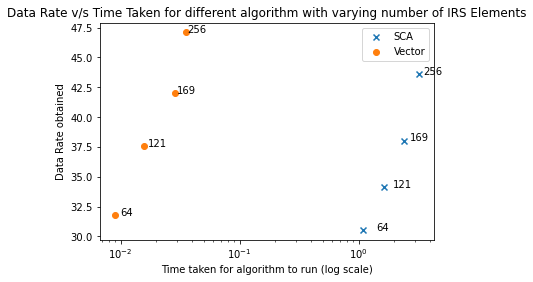

In [17]:
plt.scatter(*zip(*sca.mean(axis = 1)),label="SCA",marker="x")
plt.scatter(*zip(*vector.mean(axis = 1)),label="Vector")
plt.legend()
for i, txt in enumerate(N_xs):
    plt.annotate(txt**2, (sca.mean(axis = 1)[i][0]+0.3, sca.mean(axis = 1)[i][1]))
    plt.annotate(txt**2, (vector.mean(axis = 1)[i][0]+0.001, vector.mean(axis = 1)[i][1]))
plt.title("Data Rate v/s Time Taken for different algorithm with varying number of IRS Elements")
plt.ylabel("Data Rate obtained")
plt.xlabel("Time taken for algorithm to run (log scale)")
plt.xscale("log")

# SCA Using Vector Initialization

In [31]:
N_iter = 100
N_xs = [8,11,13,16]
vector = np.zeros((len(N_xs),N_iter,2))
sca = np.zeros((len(N_xs),N_iter,2))
### System Parameters
# General parameters
j = 0
for N_x in N_xs:
    print(f"Doing it for {N_x}")
    K = 500 # sub carriers
    L = 20 # taps

    M = 2 #Num of discrete phase-shifts

    N_y = N_x
    N_e = N_x * N_y #Number of IRS elements

    # Channel information
    #direct channel
    beta_d = (10)**-3 * (10)**-3
    k_d = 0
    const_d = 0
    #BS to IRS channel
    beta_bi =  (10)**-3 * (1.5)**-3
    k_bi = 1
    const_bi = 0
    #IRS to User channel
    beta_iu =  (10)**-3 * (8)**-3
    k_iu = 1
    const_iu = 0
    
    for i in range(N_iter):
        ### Declaring Variables 
        det = generate_deterministic_reflectors(np.ones((N_x,N_y))).reshape((N_e,1))
        det_direct = generate_deterministic_direct(np.ones(1))[0]
        # CSI

        H_d = rician(beta=beta_d, k=k_d,num_carriers=K,h_d=det_direct)
        H_bi = rician(beta=beta_bi,k=k_bi,num_carriers=K,num_channels=N_e,h_d=det)
        H_iu = rician(beta=beta_iu,k=k_iu,num_carriers=K,num_channels=N_e,h_d=det)

        ## Theta

        IRS_config = get_config()
        Direct = np.ones(1).astype(np.complex128)
        Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))


        ## Final channel
        H_id = np.multiply(H_bi,H_iu)
        H = np.concatenate((H_d,H_id), axis=1)
        G_comp = H * Theta.T ## Channel Across different subcarriers and subchannels
        G = H @ Theta ## Final  Channel across different subcarriers

        ## Creating Signal 

        ## Power Distribution over different subcarriers: 
        P = np.random.dirichlet(np.ones(K),size=1)
        P_max = 10 ## Power Budget in mW
        ## Symbol to be sent of 1mW
        s = 1e-3 * P_max
        w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
        sig  = w*s # Final Symbol Transmitted
        sig = sig * P.T
        t = time.process_time()
        R = return_rate_strongest_tap(H,N_e,K,L,sig)
        vector[j][i]=time.process_time()-t,R
        t = time.process_time()
        R = return_rate_sca_vectorinit(H,N_e,K,L,sig)
        sca[j][i]=time.process_time()-t,R
        if (i%10==0):
            print(f'Iteration {i} going on for {N_x}')
    j += 1

Doing it for 8
Iteration 0 going on for 8
Iteration 10 going on for 8
Iteration 20 going on for 8
Iteration 30 going on for 8
Iteration 40 going on for 8
Iteration 50 going on for 8
Iteration 60 going on for 8
Iteration 70 going on for 8
Iteration 80 going on for 8
Iteration 90 going on for 8
Doing it for 11
Iteration 0 going on for 11
Iteration 10 going on for 11
Iteration 20 going on for 11
Iteration 30 going on for 11
Iteration 40 going on for 11
Iteration 50 going on for 11
Iteration 60 going on for 11
Iteration 70 going on for 11
Iteration 80 going on for 11
Iteration 90 going on for 11
Doing it for 13
Iteration 0 going on for 13
Iteration 10 going on for 13
Iteration 20 going on for 13
Iteration 30 going on for 13
Iteration 40 going on for 13
Iteration 50 going on for 13
Iteration 60 going on for 13
Iteration 70 going on for 13
Iteration 80 going on for 13
Iteration 90 going on for 13
Doing it for 16
Iteration 0 going on for 16
Iteration 10 going on for 16
Iteration 20 going on f

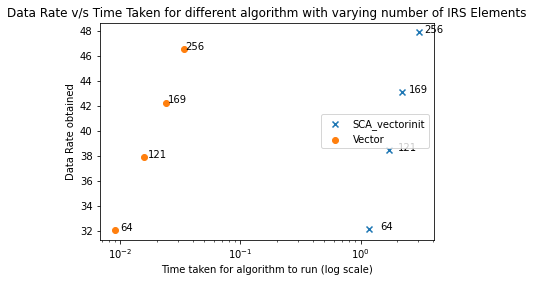

In [33]:
plt.scatter(*zip(*sca.mean(axis = 1)),label="SCA_vectorinit",marker="x")
plt.scatter(*zip(*vector.mean(axis = 1)),label="Vector")
plt.legend()
for i, txt in enumerate(N_xs):
    plt.annotate(txt**2, (sca.mean(axis = 1)[i][0]+0.3, sca.mean(axis = 1)[i][1]))
    plt.annotate(txt**2, (vector.mean(axis = 1)[i][0]+0.001, vector.mean(axis = 1)[i][1]))
plt.title("Data Rate v/s Time Taken for different algorithm with varying number of IRS Elements")
plt.ylabel("Data Rate obtained")
plt.xlabel("Time taken for algorithm to run (log scale)")
plt.xscale("log")

## Data Rate Expression

Different Possibilities of Plots:

Number of Elements Varying: Rates Obtained v/s Time Taken  
Number of Subcarrier Varying:  Rates Obtained v/s Time Taken  
Number of Discrete Levels Varying:  Rates Obtained v/s Time Taken  


## SDP Based Approach

In [ ]:
import numpy as np
from cvxopt import matrix
import picos

N_e= 64
H_id = np.matrix(H_id)
H_d = np.matrix(H_d)
A_ = H_id.H @ H_id
u_ = H_id.H @ H_d
u_abs2 = picos.Constant(np.multiply(u_,u_.conjugate()))
comp_eye = np.eye(N_e).astype(np.complex128)
comp_zero = np.zeros_like(A_)
M_u = np.concatenate([A_, np.eye(N_e)], axis=0)
M_l = np.concatenate([np.eye(N_e),np.zeros_like(A_)], axis=0)
M_ = picos.Constant(np.matrix(np.concatenate([M_u, M_l], axis=1)))
W_ = picos.HermitianVariable("W_", 2*N_e)
# Define and solve the CVXPY problem.
# The operator >> denotes matrix inequality.


prob = picos.Problem()
prob.set_objective("max",picos.trace(W_*M_))
constraints = [W_ >> 0]
constraints += [
    W_[i,i].real <= 1 for i in range(Ne)
]

constraints += [
    W_[dict(enumerate([range(Ne,2*Ne)]*2))] == u_abs2[:]
]
prob.add_list_of_constraints(constraints)
print(prob)
prob.solve(solver="cvxopt",verbose=True)
print("\nOptimal W_:", W_, sep="\n")
W_sub = W_.value[0:Ne,0:Ne]
w,v = np.linalg.eig(W_sub)
Urnk = len([s for s in w if abs(s) > 1e-6])
print("\nrank(W_sub) =", Urnk)
if np.linalg.matrix_rank(W_sub) ==1:
    theta_init = v @ np.sqrt(w).reshape(-1,1)
else:
    Q = 100
    phi = []
    prod = v @ np.diag(np.sqrt(w))
    P = []
    for q in range(Q):
        r = math.sqrt(0.5)*np.random.randn(Ne, 2).view(np.complex128).reshape(-1,1)
        phiq = np.exp(1j*np.angle(prod @ r))
        Pq = np.linalg.norm(H_d+ H_id@phiq)
        phi.append(phiq)
        P.append(Pq)
    theta_init = phi[[i for i,p in enumerate(P) if p ==max(P)][0]]

In [ ]:
H_id = np.matrix(H_id)
H_d = np.matrix(H_d)
A_ = H_id.H @ H_id
u_ = H_id.H @ H_d
u_abs2 = np.multiply(u_,u_.conjugate())

In [24]:
M_u = np.concatenate([A_, np.eye(N_e)], axis=0)
M_l = np.concatenate([np.eye(N_e),np.zeros_like(A_)], axis=0)
M_ = np.matrix(np.concatenate([M_u, M_l], axis=1))
W_ = cp.Variable(shape=(2*N_e,2*N_e), hermitian=True)

In [34]:
# Define and solve the CVXPY problem.
# The operator >> denotes matrix inequality.
constraints = [W_ >> 0]
constraints += [
    cp.real(W_[i][i]) <= 1 for i in range(N_e)
]

constraints += [
    W_[i+N_e][i+N_e] == u_abs2[i] for i in range(N_e)
]
obj = cp.Maximize(cp.real(cp.trace(W_ @ M_)))
prob = cp.Problem(obj,
                  constraints)

prob.solve(verbose=True, max_iters = 10)

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Sep 07 11:20:45 PM: Your problem has 262144 variables, 513 constraints, and 0 parameters.
(CVXPY) Sep 07 11:20:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 07 11:20:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 07 11:20:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 07 11:20:45 PM: Compiling problem (target solver=SCS).
(CVXPY) Sep 07 11:20:45 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> C

/home/adit/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


88.79957982187288

In [35]:
W_sub = W_.value[0:N_e,0:N_e]
w,v = np.linalg.eig(W_sub)
if np.linalg.matrix_rank(W_sub) ==1:
    theta_init = v @ np.sqrt(w).reshape(-1,1)
else:
    Q = 100
    phi = []
    prod = v @ np.diag(np.sqrt(w))
    P = []
    for q in range(Q):
        r = math.sqrt(0.5)*np.random.randn(256, 2).view(np.complex128).reshape(-1,1)
        phiq = np.exp(1j*np.angle(prod @ r))
        Pq = np.linalg.norm(H_d+ H_id@phiq)
        phi.append(phiq)
        P.append(Pq)
    theta_init = phi[[i for i,p in enumerate(P) if p ==max(P)][0]]

In [ ]:
# C bits
- Number of Channels, Number of IRS elements, Number of Discrete Phase Shifts, Power Distribution


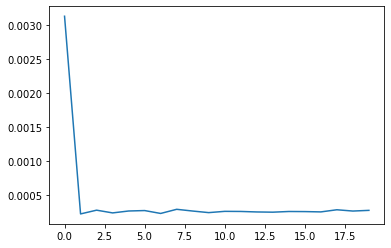

In [18]:
time_h = np.fft.ifft(H,K,axis=0)[:L,:]
plt.plot(np.abs(time_h).sum(axis=1))
plt.show()

In [19]:
np.abs(time_h).sum(axis=1)

array([0.00312832, 0.00022167, 0.00027675, 0.00023652, 0.00026459,
       0.000271  , 0.00022852, 0.00028948, 0.00026393, 0.00024079,
       0.00025941, 0.00025788, 0.0002506 , 0.00024723, 0.00025731,
       0.00025586, 0.00025126, 0.00028269, 0.00026382, 0.00027394])

In [ ]:
estimate = np.load("/work/IRS-Paper/estimate_d1.npy")

In [ ]:
estimate.shape

(500, 4097)

In [ ]:
N_e = 4096
#Theta = strongest_tap(estimate,1,N_e+1,K,L)
Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

0.7170185379853654

In [ ]:
N_e = 4096
Theta = strongest_tap(estimate,1,N_e+1,K,L)
# Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

(257,)

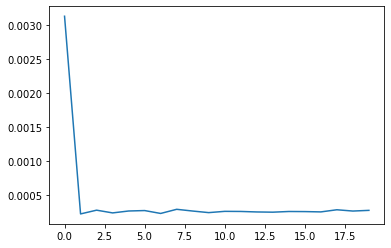

In [18]:
time_h = np.fft.ifft(H,K,axis=0)[:L,:]
plt.plot(np.abs(time_h).sum(axis=1))
plt.show()

In [19]:
np.abs(time_h).sum(axis=1)

array([0.00312832, 0.00022167, 0.00027675, 0.00023652, 0.00026459,
       0.000271  , 0.00022852, 0.00028948, 0.00026393, 0.00024079,
       0.00025941, 0.00025788, 0.0002506 , 0.00024723, 0.00025731,
       0.00025586, 0.00025126, 0.00028269, 0.00026382, 0.00027394])

In [ ]:
estimate = np.load("/work/IRS-Paper/estimate_d1.npy")

In [ ]:
estimate.shape

(500, 4097)

In [ ]:
N_e = 4096
#Theta = strongest_tap(estimate,1,N_e+1,K,L)
Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

0.7170185379853654

In [ ]:
N_e = 4096
Theta = strongest_tap(estimate,1,N_e+1,K,L)
# Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

(257,)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b319ffc-f2ce-4490-9e28-3a7eb21abad0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>